Copyright (c) MONAI Consortium  
Licensed under the Apache License, Version 2.0 (the "License");  
you may not use this file except in compliance with the License.  
You may obtain a copy of the License at  
&nbsp;&nbsp;&nbsp;&nbsp;http://www.apache.org/licenses/LICENSE-2.0  
Unless required by applicable law or agreed to in writing, software  
distributed under the License is distributed on an "AS IS" BASIS,  
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  
See the License for the specific language governing permissions and  
limitations under the License.

# Image Restoration with Restormer in MONAI

## Introduction

Image restoration is the process of reconstructing a high-quality image by removing degradations (e.g., noise, blur, movement) from a degraded image. Imperfections frequently manifest as speckle, streaks, intensity variations across the image, or motion blur, all of which can mask vital clues. Image restoration aims to remove these imperfections and enhance the image's visual quality and information content. In fields like medical imaging, the ability to refine visual data via restoration is of paramount importance, as enhancing clarity and information content directly impacts the reliability of diagnoses and subsequent treatment planning. 

In recent years, data-driven Deep Learning architectures are setting the new benchmark in image restoration, leveraging vast datasets to learn complex patterns, significantly outpacing conventional restoration techniques in performance. A key innovation driving this progress comes from the Transformer architecture, due to its capacity for capturing long-range dependencies. 

Building on this foundation, models like Restormer demonstrate how Transformer-based designs can be effectively adapted to understand and reconstruct complex image details during restoration. The Restormer implements a computationally efficient channel attention to tackle image restoration, achieving state-of-the-art performance. Briefly, the Restormer employs a multi-scale architecture, incorporating a Transformer-based encoder-decoder with skip connections and a cross-attention mechanism. This design allows the model to capture both local and global contextual information, making it well-suited for complex image restoration tasks (see [Restormer: Efficient Transformer for High-Resolution Image Restoration](https://arxiv.org/abs/2111.09881)). Thus, we will leverage this model from the MONAI framework to demonstrate its capabilities in image restoration.


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Project-MONAI/tutorials/blob/main/2d_regression/image_restoration.ipynb)

## Setup environment

We will install the latest `dev` branch of MONAI where the Restormer is available. Also, we use  `pip install` with the `BUILD_MONAI=1` flag. This will fetch the most recent source code from the MONAI repository's development branch, build MONAI's C++/CUDA extensions, and install the package.

Setting `env BUILD_MONAI=1` ensures that when calling the relevant Python modules, MONAI will prefer those extensions instead of the PyTorch/Python native implementations.

(The compilation may take a few to 10+ minutes.)

In [1]:
%env BUILD_MONAI=1
!python -c "import monai" || pip install -q monai-weekly

env: BUILD_MONAI=1


## Setup imports

In [ ]:
from monai.utils import set_determinism, first
from monai.transforms import (
    EnsureChannelFirstD,
    Compose,
    LoadImageD,
    ScaleIntensityd,
    RandGaussianNoiseD,
    RandGaussianSmoothD,
)
from monai.config import print_config
from monai.data import DataLoader, Dataset, CacheDataset
from monai.networks.nets.restormer import Restormer
from monai.apps import MedNISTDataset
from monai.losses import SSIMLoss

import os
import torch
import matplotlib.pyplot as plt
import tempfile


print_config()
set_determinism(42)

MONAI version: 1.5.dev2518
Numpy version: 2.2.5
Pytorch version: 2.7.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 09b361dbe4c2be5289c7e2d2f6c10c5166eee273
MONAI __file__: /Users/<username>/miniconda3/envs/monai_dev/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: 5.4.3
Nibabel version: 5.3.2
scikit-image version: 0.25.2
scipy version: 1.15.2
Pillow version: 11.2.1
Tensorboard version: 2.19.0
gdown version: 5.2.0
TorchVision version: 0.22.0
tqdm version: 4.67.1
lmdb version: 1.6.2
psutil version: 7.0.0
pandas version: 2.2.3
einops version: 0.8.1
transformers version: 4.40.2
mlflow version: 2.22.0
pynrrd version: 1.1.3
clearml version: 2.0.0rc0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



# Construct Pairwise Training Inputs for Restoration

We use the `MedNISTDataset` object to download and unzip the actual data files. We select the hand X-ray class for this demonstration.

To create training pairs suitable for an image restoration task, we structure our data dictionaries with two keys: `"original_hand"` and `"noisy_hand"`. Initially, both keys point to the same clean hand X-ray image path.

During the data loading and transformation pipeline:
1.  The `"original_hand"` image serves as the clean, high-quality target image.
2.  The `"noisy_hand"` image, initially identical to the original one, undergoes a series of **random synthetic degradations**. For this small example, we apply common degradations like Gaussian noise and Gaussian blur (smoothing) specifically to the `"noisy_hand"`. This simulates realistic scenarios where images might be corrupted by sensor noise, motion blur, or varying acquisition settings.

In [2]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
if directory is not None:
    os.makedirs(directory, exist_ok=True)
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

train_data = MedNISTDataset(root_dir=root_dir, section="training", download=True, transform=None)
training_datadict = [
    {"original_hand": item["image"], "noisy_hand": item["image"]}
    for item in train_data.data
    if item["label"] == 4  # label 4 is for xray hands
]
print("\n first training items: ", training_datadict[:3])

/var/folders/l9/mzf3xz016nn449t2nlqp0k680000gn/T/tmpyd0u90wu


MedNIST.tar.gz: 59.0MB [00:02, 28.6MB/s]                              

2025-05-22 08:47:35,940 - INFO - Downloaded: /var/folders/l9/mzf3xz016nn449t2nlqp0k680000gn/T/tmpyd0u90wu/MedNIST.tar.gz


2025-05-22 08:47:36,048 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2025-05-22 08:47:36,049 - INFO - Writing into directory: /var/folders/l9/mzf3xz016nn449t2nlqp0k680000gn/T/tmpyd0u90wu.


Loading dataset: 100%|██████████| 47164/47164 [00:00<00:00, 270330.68it/s]


 first training items:  [{'original_hand': '/var/folders/l9/mzf3xz016nn449t2nlqp0k680000gn/T/tmpyd0u90wu/MedNIST/Hand/001727.jpeg', 'noisy_hand': '/var/folders/l9/mzf3xz016nn449t2nlqp0k680000gn/T/tmpyd0u90wu/MedNIST/Hand/001727.jpeg'}, {'original_hand': '/var/folders/l9/mzf3xz016nn449t2nlqp0k680000gn/T/tmpyd0u90wu/MedNIST/Hand/009015.jpeg', 'noisy_hand': '/var/folders/l9/mzf3xz016nn449t2nlqp0k680000gn/T/tmpyd0u90wu/MedNIST/Hand/009015.jpeg'}, {'original_hand': '/var/folders/l9/mzf3xz016nn449t2nlqp0k680000gn/T/tmpyd0u90wu/MedNIST/Hand/007610.jpeg', 'noisy_hand': '/var/folders/l9/mzf3xz016nn449t2nlqp0k680000gn/T/tmpyd0u90wu/MedNIST/Hand/007610.jpeg'}]


In [3]:
img_keys = ["original_hand", "noisy_hand"]
degradation_key = "noisy_hand"


train_transforms = Compose(
    [
        LoadImageD(keys=img_keys),
        EnsureChannelFirstD(keys=img_keys),
        ScaleIntensityd(keys=img_keys),
        RandGaussianNoiseD(keys=[degradation_key], prob=0.5, std=0.1),
        RandGaussianSmoothD(keys=[degradation_key], prob=0.5, sigma_x=(0.5, 1.5), sigma_y=(0.5, 1.5)),
        ScaleIntensityd(keys=img_keys),
    ]
)

## Visualisation of the training pairs

noisy_image shape: torch.Size([64, 64])
original_image shape: torch.Size([64, 64])


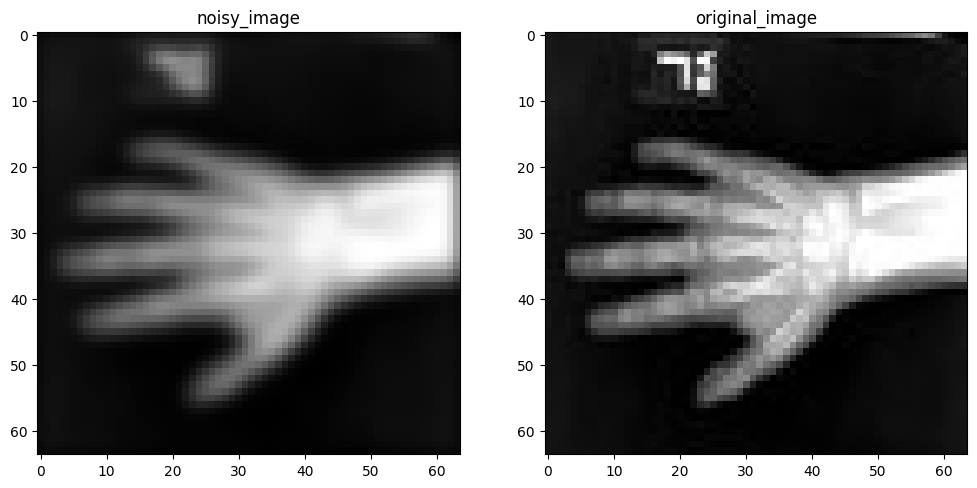

In [4]:
check_ds = Dataset(data=training_datadict, transform=train_transforms)
check_loader = DataLoader(check_ds, batch_size=1, shuffle=True)
check_data = first(check_loader)
original_image = check_data["original_hand"][0][0]
noisy_image = check_data["noisy_hand"][0][0]

print(f"noisy_image shape: {noisy_image.shape}")
print(f"original_image shape: {original_image.shape}")

plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("noisy_image")
plt.imshow(noisy_image, cmap="gray")
plt.subplot(1, 2, 2)
plt.title("original_image")
plt.imshow(original_image, cmap="gray")

plt.show()

## Create the training pipelines

We use a `CacheDataset` to capture the training pairs and accelerate the training process. The MedNISTDataset provides pairs of "noisy" and "original" images. For demonstration purposes, we treat this as an image restoration problem: the "noisy" image is a degraded version of the "original" reference image (e.g., due to simulated movement or noise). The goal is to restore the noisy image to match the original image.


In [5]:
train_ds = CacheDataset(data=training_datadict[:1000], transform=train_transforms, cache_rate=1.0, num_workers=0)
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=0)

Loading dataset: 100%|██████████| 1000/1000 [00:00<00:00, 1600.61it/s]


## Model and Training

Now, let's initialize the Restormer model and train it to restore the noisy images. Since this is just a tutorial, we will initialize a small Restormer model with a small size configuration for quick experimentation: 

- `dim=32`: the embedding dimension (feature width) at the first stage.
- `num_blocks=[2, 2]`: 2 encoder and 2 decoder blocks.
- `num_heads=[2, 2]`: 2 attention heads at each stage.
- `refinement=1`: 1 refinement block at the bottleneck.

When training image restoration models, common regression losses include `MSELoss`, `PSNRLoss`, and `SSIMLoss`. Here, we use `SSIMLoss` because it encourages the model to focus on matching the structural similarity (shape and details) of the hands, rather than just restoring absolute pixel values.


In [6]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

model = Restormer(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    dim=32,
    num_blocks=[2, 2],
    heads=[2, 2],
    num_refinement_blocks=1,
).to(device)
image_loss = SSIMLoss(spatial_dims=2, data_range=1.0)
optimizer = torch.optim.Adam(model.parameters(), 1e-5)

## The training loops

In [7]:
max_epochs = 50
epoch_loss_values = []


for epoch in range(max_epochs):
    model.train()
    epoch_loss, step = 0, 0

    # No inner tqdm bar here
    for batch_data in train_loader:
        step += 1
        optimizer.zero_grad()

        noisy = batch_data["noisy_hand"].to(device)
        original = batch_data["original_hand"].to(device)
        pred_image = model(noisy)
        pred_image = torch.sigmoid(pred_image)

        loss = image_loss(input=pred_image, target=original)
        loss.backward()
        optimizer.step()
        current_loss = loss.item()
        epoch_loss += current_loss

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)

    # Update the outer bar's postfix with the final average epoch loss
    print({"Epoch": epoch + 1, "Avg Epoch Loss": f"{epoch_loss:.4f}"})

{'Epoch': 1, 'Avg Epoch Loss': '0.8336'}
{'Epoch': 2, 'Avg Epoch Loss': '0.7150'}
{'Epoch': 3, 'Avg Epoch Loss': '0.6269'}
{'Epoch': 4, 'Avg Epoch Loss': '0.5621'}
{'Epoch': 5, 'Avg Epoch Loss': '0.5125'}
{'Epoch': 6, 'Avg Epoch Loss': '0.4738'}
{'Epoch': 7, 'Avg Epoch Loss': '0.4314'}
{'Epoch': 8, 'Avg Epoch Loss': '0.3770'}
{'Epoch': 9, 'Avg Epoch Loss': '0.2988'}
{'Epoch': 10, 'Avg Epoch Loss': '0.2397'}
{'Epoch': 11, 'Avg Epoch Loss': '0.2179'}
{'Epoch': 12, 'Avg Epoch Loss': '0.2028'}
{'Epoch': 13, 'Avg Epoch Loss': '0.1915'}
{'Epoch': 14, 'Avg Epoch Loss': '0.1799'}
{'Epoch': 15, 'Avg Epoch Loss': '0.1732'}
{'Epoch': 16, 'Avg Epoch Loss': '0.1634'}
{'Epoch': 17, 'Avg Epoch Loss': '0.1560'}
{'Epoch': 18, 'Avg Epoch Loss': '0.1492'}
{'Epoch': 19, 'Avg Epoch Loss': '0.1438'}
{'Epoch': 20, 'Avg Epoch Loss': '0.1391'}
{'Epoch': 21, 'Avg Epoch Loss': '0.1323'}
{'Epoch': 22, 'Avg Epoch Loss': '0.1317'}
{'Epoch': 23, 'Avg Epoch Loss': '0.1247'}
{'Epoch': 24, 'Avg Epoch Loss': '0.1218'}
{

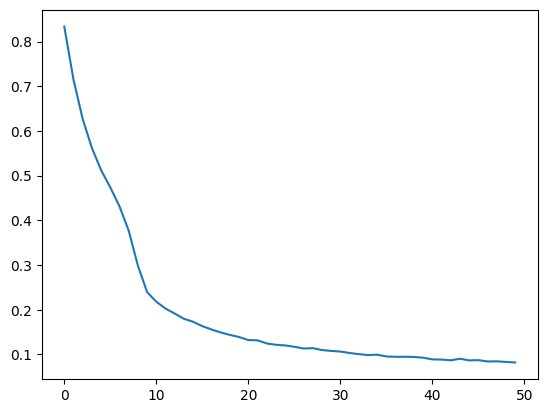

In [8]:
%matplotlib inline
plt.plot(epoch_loss_values)

# Visualise some validation results
This section creates a set of previously unseen pairs of noisy vs original hands,
and use the network to predict the transformation between each pair.

In [9]:
val_ds = CacheDataset(data=training_datadict[2000:2500], transform=train_transforms, cache_rate=1.0, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=16, num_workers=0)
model.eval()  # Set model to evaluation mode

with torch.no_grad():  # Disable gradient calculation for inference
    for batch_data in val_loader:
        noisy = batch_data["noisy_hand"].to(device)
        original = batch_data["original_hand"].to(device)
        # Pass only the noisy image, consistent with training
        pred_image = model(noisy)
        pred_image = torch.sigmoid(pred_image)
        break  # Process only the first batch for visualization

original_image = original.detach().cpu().numpy()[:, 0]
noisy_image = noisy.detach().cpu().numpy()[:, 0]
pred_image = pred_image.detach().cpu().numpy()[:, 0]

Loading dataset: 100%|██████████| 500/500 [00:00<00:00, 852.19it/s]


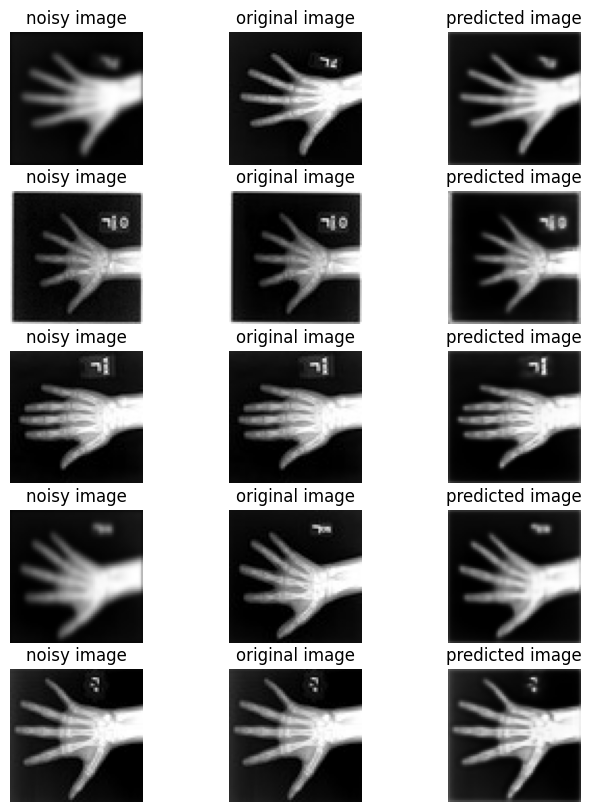

In [10]:
%matplotlib inline
batch_size = 5
plt.subplots(batch_size, 3, figsize=(8, 10))
for b in range(batch_size):
    # noisy image
    plt.subplot(batch_size, 3, b * 3 + 1)
    plt.axis("off")
    plt.title("noisy image")
    plt.imshow(noisy_image[b], cmap="gray")
    # original image
    plt.subplot(batch_size, 3, b * 3 + 2)
    plt.axis("off")
    plt.title("original image")
    plt.imshow(original_image[b], cmap="gray")
    # predicted restored image
    plt.subplot(batch_size, 3, b * 3 + 3)
    plt.axis("off")
    plt.title("predicted image")
    plt.imshow(pred_image[b], cmap="gray")
plt.axis("off")
plt.show()